<a href="https://colab.research.google.com/github/motkeg/Msc-Project/blob/master/fashion_mnist_gan_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fasion_MNIST GAN (Generative Adversarial Networks)

### import and define sime variables

In [0]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
                                    BatchNormalization, Activation, ZeroPadding2D,
                                    LeakyReLU, UpSampling2D, Conv2D)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import initializers

tf.keras.backend.set_image_data_format('channels_first')

JOB_DIR = "./weights/gan_v2"    
USE_TPU = False
EPOCHS = 10
BATCH= 128
SAVE = 100
USE_TPU = False

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)
if not os.path.exists("./samples/fashion_mnist_v2"):
    os.makedirs("./samples/fashion_mnist_v2")
    
if not os.path.exists(JOB_DIR):
    os.makedirs(JOB_DIR)
    

### define helpfull methods

In [0]:

import matplotlib.pyplot as plt

 # Plot the loss from each batch
def plot_loss(epoch,d_Losses,g_Losses):
    plt.figure(figsize=(10, 8))
    plt.plot(d_Losses, label='Discriminitive loss')
    plt.plot(d_Losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated images
def plot_generated_images(imgs , epoch, examples=25, dim=(5,5), figsize=(5, 5)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    plt.figure(figsize=figsize)
    for i in range(imgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(imgs[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    name = "fashion_mnist_v2_{}.png".format(epoch)
    plt.savefig('./samples/fashion_mnist_v2/' + name)


### define the GAN class
the __call__() method is the 'action' of the model - make it running

In [0]:


class DCGAN_V2():
  
    def __init__(self):
        
        # The results are a little better when the dimensionality of the random vector is only 10.
        # The dimensionality has been left at 100 for consistency with other GAN implementations.
        self.randomDim = 100

        # Load data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train = (X_train.astype(np.float32) - 127.5)/127.5
        #self.X_train = np.expand_dims(X_train, -1)
        self.X_train = X_train[:, np.newaxis, :, :]

        self.tensorboard = keras.callbacks.TensorBoard(log_dir=JOB_DIR+ "/logs",
                                                        batch_size=BATCH,
                                                        write_graph=True,
                                                        histogram_freq=0,
                                                        write_images=True,
                                                        write_grads=True)
        #self.checkpointer  = keras.callbacks.ModelCheckpoint(filepath=f'{FLAGS.job_dir}/gan_model.best.hdf5', verbose = 1, save_best_only=True)

        # Optimizer
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)

        self.discriminator = self.build_D()
        self.generator = self.build_G()

        # Combined network
        self.discriminator.trainable = False
        ganInput = Input(shape=(self.randomDim,))
        x = self.generator(ganInput)
        ganOutput = self.discriminator(x)
        self.gan = Model(inputs=ganInput, outputs=ganOutput)
        self.gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.dLosses = []
        self.gLosses = []


    def build_G(self):
      with tf.variable_scope("Generatoe"):
          # Generator
          generator = Sequential()
          generator.add(Dense(128*7*7, input_dim=self.randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
          generator.add(LeakyReLU(0.2))
          generator.add(Reshape((128,7, 7)))
          generator.add(UpSampling2D(size=(2, 2)))
          generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
          generator.add(LeakyReLU(0.2))
          generator.add(UpSampling2D(size=(2, 2)))
          generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
          generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
          generator.summary()
      return generator


    def build_D(self):
        with tf.variable_scope("Discriminator"):
          # Discriminator
          discriminator = Sequential()

          discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1,28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
          discriminator.add(LeakyReLU(0.2))
          discriminator.add(Dropout(0.3))
          discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
          discriminator.add(LeakyReLU(0.2))
          discriminator.add(Dropout(0.3))
          discriminator.add(Flatten())
          discriminator.add(Dense(1, activation='sigmoid'))
          discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
          discriminator.summary()
        return discriminator

        


    def __call__(self, epochs=1, batchSize=BATCH):
        batchCount = self.X_train.shape[0] // batchSize
        print (f'Epochs:{epochs}\nBatch size: {batchSize}\t | Batches per epoch: {batchCount}')
            
        for e in range(1, epochs+1):
            print ('-'*15, 'Epoch %d' % e, '-'*15)
            for _ in tqdm(range(batchCount)):
                # Get a random set of input noise and images
                noise = np.random.normal( 0,1, size=[batchSize, self.randomDim])
                imageBatch = self.X_train[np.random.randint(0, self.X_train.shape[0], size=batchSize)]

                # Generate fake images
                generatedImages = self.generator.predict(noise)
                X = np.concatenate([imageBatch, generatedImages])

                # Labels for generated and real data
                yDis = np.zeros(2*batchSize)
                # One-sided label smoothing
                yDis[:batchSize] = 0.9

                # Train discriminator
                self.discriminator.trainable = True
                dloss = self.discriminator.train_on_batch(X, yDis)

                # Train generator
                noise = np.random.normal(0, 1, size=[batchSize,self.randomDim])
                yGen = np.ones(batchSize)
                self.discriminator.trainable = False
                gloss = self.gan.train_on_batch(noise, yGen)

            print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e,epochs, dloss, 100*dloss, gloss))

            self.dLosses.append(dloss)
            self.gLosses.append(gloss)

            # write tensorboard logs
            self.tensorboard.set_model(self.discriminator)
            self.tensorboard.on_epoch_end(e,{"loss":dloss , "accuracy":dloss})
            
            self.tensorboard.set_model(self.generator)
            self.tensorboard.on_epoch_end(e,{"loss":gloss , "accuracy":dloss})

            if e == 1 or e % 5 == 0:
                noise = np.random.normal(0, 1, size=[25, self.randomDim])
                imgs = self.generator.predict(noise)
                plot_generated_images(imgs,e)
                self.save_models(e)

        # Plot losses from every epoch
        plot_loss(e , self.dLosses,self.gLosses)

    # Save the generator and discriminator networks (and weights) for later use
    def save_models(self,epoch):
        self.generator.save(f'{JOB_DIR}/dcgan_generator.h5')
        self.discriminator.save(f'{JOB_DIR}/dcgan_discriminator.h5')
        self.gan.save(f'{JOB_DIR}/dcgan_combined.h5')   
   
  
  
    def named_logs(self,model, logs):
        result = {}
        for l in zip(model.metrics_names, logs):
            result[l[0]] = l[1]
        return result     


## Start the training

4423680/4422102 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 14, 14)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten (Flat

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs:10
Batch size: 128	 | Batches per epoch: 468
--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.95it/s]


1/10 [D loss: 0.663321, acc.: 66.33%] [G loss: 0.858347]


  0%|          | 2/468 [00:00<00:32, 14.13it/s]

--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.10it/s]


2/10 [D loss: 0.608519, acc.: 60.85%] [G loss: 0.993758]


  0%|          | 2/468 [00:00<00:32, 14.35it/s]

--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.90it/s]


3/10 [D loss: 0.588887, acc.: 58.89%] [G loss: 1.090610]


  0%|          | 2/468 [00:00<00:33, 13.90it/s]

--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.91it/s]


4/10 [D loss: 0.598088, acc.: 59.81%] [G loss: 1.124763]


  0%|          | 2/468 [00:00<00:33, 14.05it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.08it/s]


5/10 [D loss: 0.638022, acc.: 63.80%] [G loss: 0.972452]


  0%|          | 2/468 [00:00<00:33, 13.86it/s]

--------------- Epoch 6 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.06it/s]


6/10 [D loss: 0.617041, acc.: 61.70%] [G loss: 1.121458]


  0%|          | 2/468 [00:00<00:33, 13.83it/s]

--------------- Epoch 7 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.75it/s]


7/10 [D loss: 0.592708, acc.: 59.27%] [G loss: 1.131540]


  0%|          | 2/468 [00:00<00:33, 14.11it/s]

--------------- Epoch 8 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.11it/s]


8/10 [D loss: 0.633262, acc.: 63.33%] [G loss: 1.077609]


  0%|          | 2/468 [00:00<00:33, 13.95it/s]

--------------- Epoch 9 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.97it/s]


9/10 [D loss: 0.644172, acc.: 64.42%] [G loss: 0.991850]


  0%|          | 2/468 [00:00<00:32, 14.27it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.82it/s]


10/10 [D loss: 0.598709, acc.: 59.87%] [G loss: 1.014469]


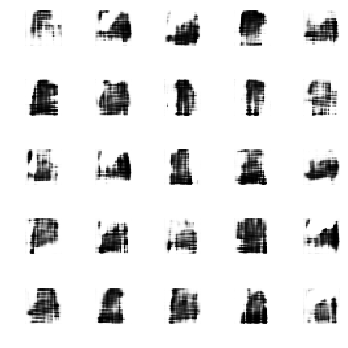

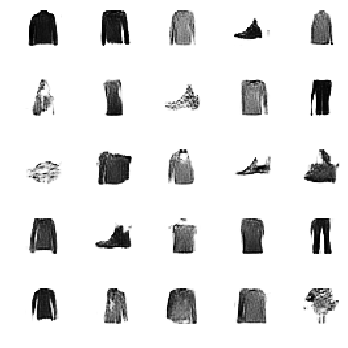

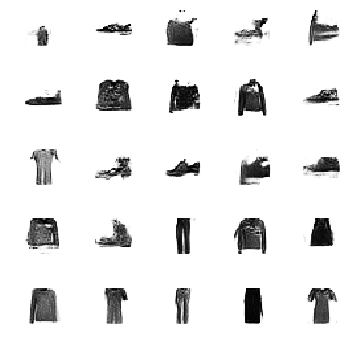

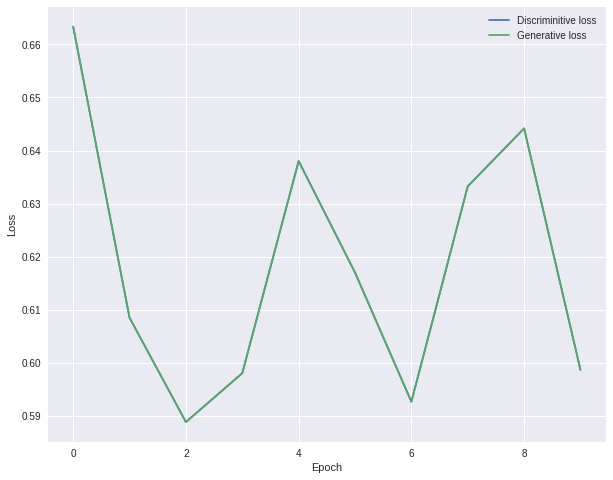

In [4]:

model = DCGAN_V2()
model(epochs=EPOCHS)

## You can run this cell below as a standalone 


*   you need the weights file of this model :   <a href="https://colab.research.google.com/github/motkeg/Msc-Project/blob/master/fashion_cnn_tpu.ipynb\" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

     
*   you need the weights of the model that trained above



```
the files need to be like this:
- dcgan_generator.h5
- fashion-cnn-weights.best.hdf5
```



Runs: 11
trouser


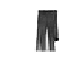

In [34]:

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

PREDICT = 'trouser'


# Create a wall of generated images
def plot_images(imgs , dim=(5,5), figsize=(5, 5)):
    plt.figure(figsize=figsize)
    for i in range(imgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(imgs[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
       
                   
label  = " "   
runs =0
fashion_cnn =  keras.models.Sequential()
fashion_cnn.add(keras.layers.Reshape((28,28,1)))
          
generator  = load_model("dcgan_generator.h5")
model = load_model('fashion-cnn-weights.best.hdf5')
fashion_cnn.add(model)

#fashion_cnn = keras.models.Model(keras.layers.Reshape((28,28,1)), model.output)

while label != PREDICT:
  runs +=1
  noise = np.random.normal(0, 1, size=[1, 100]) # generate one image 
  imgs = generator.predict(noise)
  score  = fashion_cnn.predict(imgs) 
  indx  = list(score[0]).index(max(score[0]))
  #print(score[0])
  #print(indx)
  label = LABEL_NAMES[indx]
print("Runs:",runs)  
print(label)
plot_images(imgs)  
  
